# Main Launcher

In [0]:
import sagemaker
import boto3
from sagemaker.analytics import TrainingJobAnalytics
from sagemaker.rl import RLEstimator
%matplotlib inline

### Setup S3 bucket

Set up the linkage and authentication to the S3 bucket.

In [0]:
sage_session = sagemaker.session.Session()
s3_bucket = sage_session.default_bucket()  
s3_output_path = 's3://{}/'.format(s3_bucket)
print("S3 bucket path: {}".format(s3_output_path))

S3 bucket path: s3://sagemaker-us-east-2-320208962352/


#YOU CAN CHANGE VARIABLE HERE!
Here you should change job prefix in order to run different problems and different algorithms.*

In [0]:
job_name_prefix = 'news-vendor-ppo-lead-time-2-ppo-default' #change job prefix here
instance_type = "ml.m5.large"
role = sagemaker.get_execution_role()
print("Using IAM role arn: {}".format(role))

Using IAM role arn: arn:aws:iam::320208962352:role/service-role/AmazonSageMaker-ExecutionRole-20200403T011720


### Define the Sagemaker-RL docker image for Ray

We will use the `TensorFlow Ray` for this project. For a list of available RL images see https://github.com/aws/sagemaker-rl-container 

In [0]:
cpu_or_gpu = 'gpu' if instance_type.startswith('ml.p') else 'cpu'
aws_region = boto3.Session().region_name
custom_image_name = "520713654638.dkr.ecr.{}.amazonaws.com/sagemaker-rl-tensorflow:ray0.6.5-{}-py3".format(aws_region, cpu_or_gpu)
print("Using ECR image %s" % custom_image_name)

Using ECR image 520713654638.dkr.ecr.us-east-2.amazonaws.com/sagemaker-rl-tensorflow:ray0.6.5-cpu-py3


### Define Metric
A list of dictionaries that defines the metric(s) used to evaluate the training jobs. Each dictionary contains two keys: ‘Name’ for the name of the metric, and ‘Regex’ for the regular expression used to extract the metric from the logs.

In [0]:
metric_definitions = [{'Name': 'episode_reward_mean',
  'Regex': 'episode_reward_mean: ([-+]?[0-9]*\\.?[0-9]+([eE][-+]?[0-9]+)?)'},
 {'Name': 'episode_reward_max',
  'Regex': 'episode_reward_max: ([-+]?[0-9]*\\.?[0-9]+([eE][-+]?[0-9]+)?)'},
 {'Name': 'episode_len_mean',
  'Regex': 'episode_len_mean: ([-+]?[0-9]*\\.?[0-9]+([eE][-+]?[0-9]+)?)'},
 {'Name': 'entropy',
  'Regex': 'entropy: ([-+]?[0-9]*\\.?[0-9]+([eE][-+]?[0-9]+)?)'},
 {'Name': 'episode_reward_min',
  'Regex': 'episode_reward_min: ([-+]?[0-9]*\\.?[0-9]+([eE][-+]?[0-9]+)?)'},
 {'Name': 'vf_loss',
  'Regex': 'vf_loss: ([-+]?[0-9]*\\.?[0-9]+([eE][-+]?[0-9]+)?)'},
 {'Name': 'policy_loss',
  'Regex': 'policy_loss: ([-+]?[0-9]*\\.?[0-9]+([eE][-+]?[0-9]+)?)'},                                            
]

### Define Estimator
This Estimator executes an RLEstimator script in a managed Reinforcement Learning (RL) execution environment within a SageMaker Training Job. The managed RL environment is an Amazon-built Docker container that executes functions defined in the supplied entry_point Python script.

#YOU CAN CHANGE VARIABLE HERE!
Here you can chnge entry point for different jobs. Each train_*.py file corresponds to some problem and some algorithm.

In [0]:
train_entry_point = "train_news_vendor_ppo.py" #change entry point here for different problems
train_job_max_duration_in_seconds = 3600 * 24 * 2

estimator = RLEstimator(entry_point=train_entry_point,
                        source_dir="src",
                        dependencies=["common/sagemaker_rl"],
                        image_name=custom_image_name,
                        role=role,
                        train_instance_type=instance_type,
                        train_instance_count=1,
                        output_path=s3_output_path,
                        base_job_name=job_name_prefix,
                        metric_definitions=metric_definitions,
                        train_max_run=train_job_max_duration_in_seconds,
                        hyperparameters={}
                       )

In [0]:
estimator.fit(wait=False)
job_name = estimator.latest_training_job.job_name
print("Training job: %s" % job_name)

### Visualization

RL training can take a long time.  So while it's running there are a variety of ways we can track progress of the running training job.  Some intermediate output gets saved to S3 during training, so we'll set up to capture that.

#YOU CAN CHANGE VARIABLE HERE!
If you are tired of waiting, you can take a look at different plots for different problems and jobs. Just redefine job_name from previously selected job_name for last estimator, take job name from your aws console.
https://us-east-2.console.aws.amazon.com/sagemaker/home/jobs

In [0]:
#job_name = 'news-vendor-ppo-lead-time-2-ppo-default-2020-04-05-23-06-20-105' 
#you can change job_name here in order to get results for different aws jobs

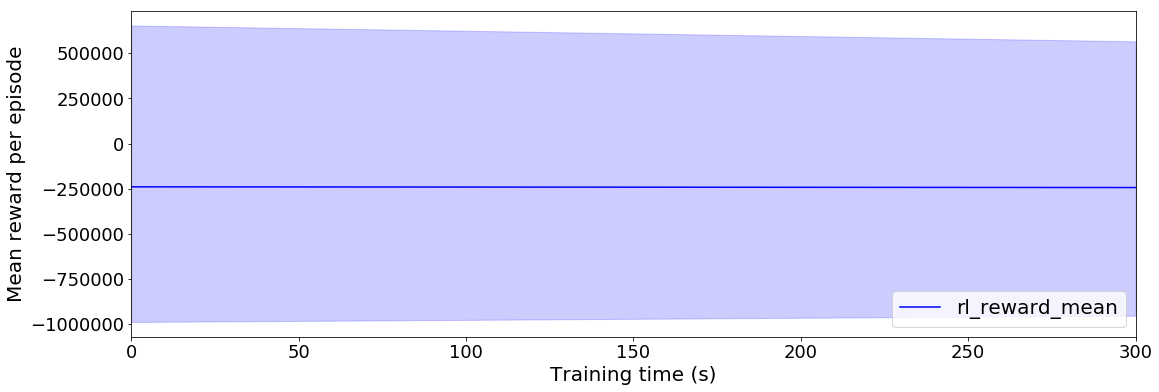

In [0]:
df = TrainingJobAnalytics(job_name, ['episode_reward_mean']).dataframe()
df_min = TrainingJobAnalytics(job_name, ['episode_reward_min']).dataframe()
df_max = TrainingJobAnalytics(job_name, ['episode_reward_max']).dataframe()
df['rl_reward_mean'] = df['value']
df['rl_reward_min'] = df_min['value']
df['rl_reward_max'] = df_max['value']
num_metrics = len(df)
    
if num_metrics == 0:
    print("No algorithm metrics found in CloudWatch")
else:
    plt = df.plot(x='timestamp', y=['rl_reward_mean'], figsize=(18,6), fontsize=18, legend=True, style='-', color=['b','r','g'])
    plt.fill_between(df.timestamp, df.rl_reward_min, df.rl_reward_max, color='b', alpha=0.2)
    plt.set_ylabel('Mean reward per episode', fontsize=20)
    plt.set_xlabel('Training time (s)', fontsize=20)
    plt.legend(loc=4, prop={'size': 20})